## 1.1 Introduction

**Dataset:** Customer Churn Dataset
<br>**Source:** Kaggle
<br>**Context:** This Dataset contains the financial information of an membership firm.
<br>**Objective:** Objective is to predict risk score of the member so that organization can avert the risk fafctor.


# 1. Importing Libraries

In [1]:
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# 2. Reading Dataset

In [2]:
df = pd.read_parquet(r'../dataset/churn.parquet')
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
age,18,32,44,37,31,13,21,42,44,45
gender,F,F,F,M,F,M,M,M,M,F
security_no,XW0DQ7H,5K0N3X1,1F2TCL3,VJGJ33N,SVZXCWB,PSG1LGF,R3CX1EA,4UJ1551,0481QNQ,ZHP4MCR
region_category,Village,City,Town,City,City,City,Town,None,Village,Town
membership_category,Platinum Membership,Premium Membership,No Membership,No Membership,No Membership,Gold Membership,Gold Membership,No Membership,Silver Membership,No Membership
joining_date,17-08-2017,28-08-2017,11-11-2016,29-10-2016,12-09-2017,08-01-2016,19-03-2015,12-07-2016,14-12-2016,30-11-2016
joined_through_referral,No,?,Yes,Yes,No,No,Yes,?,No,No
referral_id,xxxxxxxx,CID21329,CID12313,CID3793,xxxxxxxx,xxxxxxxx,CID24708,CID56614,xxxxxxxx,xxxxxxxx
preferred_offer_types,Gift Vouchers/Coupons,Gift Vouchers/Coupons,Gift Vouchers/Coupons,Gift Vouchers/Coupons,Credit/Debit Card Offers,Gift Vouchers/Coupons,Gift Vouchers/Coupons,Credit/Debit Card Offers,Without Offers,Gift Vouchers/Coupons
medium_of_operation,?,Desktop,Desktop,Desktop,Smartphone,?,Desktop,Both,Smartphone,?


| __Variable__ | __Description__ |
|     :---      |       :---      |      
| __age__			 |Age of Customer in Year 			 |
| __gender__			 |Gender of Customer (M = Male; F = Female) 			 |
| __security_no__			 | Identifier 			 |
| __region_category__			 | Customer's region category:	(`Village`, `City`, `Town`, __`None`__)		 |
| __membership_category__			 | Customer's membership category: (`Platinum Membership`, `Premium Membership`, `No Membership`, `Gold Membership`, `Silver Membership`, `Basic Membership`, )		 |
| __joining_date__			 | Customer's Joining Date			 |
| __joined_through_referral__			 | whether customer joined bank through referrals 	(`No`, __`?`__, `Yes`, )		 |
| __referral_id__			 | 	refferal_id of Customer		 |
| __preferred_offer_types__			 | Customer's Preferred Offer types while purchasing: (`Gift Vouchers/Coupons`, `Credit/Debit Card Offers`, `Without Offers`, `None`, )			 |
| __medium_of_operation__			 | Device Type used by customer's while transacting	(**`?`**, `Desktop`, `Smartphone`, `Both`, )		 |
| __internet_option__			 | 	internet_option preferred by Customer 	(`Wi-Fi`, `Mobile_Data`, `Fiber_Optic`, )	 |
| __last_visit_time__			 | 	time passed since customer last visit in (hh:mm:ss)		 |
| __days_since_last_login__			 | days passed since customer last visit in days			 |
| __avg_time_spent__			 | 	Avg. Time Spent by Customer on platform		 |
| __avg_transaction_value__			 | Avg. Transaction Value of customer		 |
| __avg_frequency_login_days__			 | Avg Frequency login Days of Customer			 |
| __points_in_wallet__			 | Points in Customer Wallet			 |
| __used_special_discount__			 | 		whether customer used special discount	(`Yes`, `No`, ) |
| __offer_application_preference__			 | 	Preference of customer whether offers should be auto applied while transacting.	(`Yes`, `No`, )	 |
| __past_complaint__			 | 			Does Customer Complaint about services offered. (`No`, `Yes`, )|
| __complaint_status__			 | 		status of complaint filed by customer (`Not Applicable`, `Solved`, `Solved in Follow-up`, `Unsolved`, `No Information Available`, ) |
| __feedback__			 | 			Feedbacks of Customer |
| __churn_risk_score__			 | 			__Target Variable:__ KPI metric describes risk whether the customer will stop using services. |

# 3. Dataset Review

## 3.1 Dataset Basic Review

In [3]:
# Display a concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   security_no                   36992 non-null  object 
 3   region_category               31564 non-null  object 
 4   membership_category           36992 non-null  object 
 5   joining_date                  36992 non-null  object 
 6   joined_through_referral       36992 non-null  object 
 7   referral_id                   36992 non-null  object 
 8   preferred_offer_types         36704 non-null  object 
 9   medium_of_operation           36992 non-null  object 
 10  internet_option               36992 non-null  object 
 11  last_visit_time               36992 non-null  object 
 12  days_since_last_login         36992 non-null  int64  
 13  a

**Inferences:**
- **Count: Records:** This dataset contains **36,992** records.
- **Columns:** There are 23 Columns in the Dataset corresponding to various attributes of bank customers.
- **Data Types:**
    - **Numerical Features:** 6
        - **int64:** 3
        - **float64:** 3
    - **Categorical Features:** 17/23
        - **object:** 17
- **Missing Values:** 3 Features contains missing values. **{region_category, preferred_offer_types, points_in_wallet}**

**Note:**
- Majority of Features in Dataset is Categorical in Nature
- Some of the Categorical Features are numerical in nature needs further processing.: (`days_since_last_login`, `avg_frequency_login_days`)

## 3.2 Summary Statistics for Numeric Variables

In [4]:
#Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36992.0,37.118161,15.867412,10.000000,23.0000,37.000,51.000,64.000000
days_since_last_login,36992.0,-41.915576,228.819900,-999.000000,8.0000,12.000,16.000,26.000000
avg_time_spent,36992.0,243.472334,398.289149,-2814.109110,60.1025,161.765,356.515,3235.578521
avg_transaction_value,36992.0,29271.194003,19444.806226,800.460000,14177.5400,27554.485,40855.110,99914.050000
points_in_wallet,33549.0,686.882199,194.063624,-760.661236,616.1500,697.620,763.950,2069.069761
churn_risk_score,36992.0,0.540982,0.498324,0.000000,0.0000,1.000,1.000,1.000000


__Numerical Features:__
- **`age`**: Youngest Customer is of 10 Years while Oldest Customer in Dataset is of 64 Years. **Avg. Age of Customers ~37** is similar to **Median Age ~37** which suggests __Normal Distribution.__

- **`days_since_last_login`**: **-999 < `days_since_last_login` < 26**; Feature contains -ive value which suggests **outliers or errors.**

- **`avg_time_spent`**: **-2814 > `avg_time_spent` > 3235**; Feature is scaler but cannot contains -ive values suggests **outliers or errors.**

- **`avg_transaction_value`**: **800 > `avg_transaction_value` > 99914**; Avg.: 29271; Median: 27554; Suggests **Normal Distribution**

- **`points_in_wallet`**: **-760 > `points_in_wallet` > 2069**; Avg. Points in Wallet: 686; Median Points in Wallet: 697; Suggests **Normal Distribution**; Majority of Customer keeps 700 points in wallet.

- **`churn_risk_score`**: **`churn_risk_score`**: **Target Variable**

## 3.3 Summary Statistics for Categorical Variables

In [5]:
# Get the summary statistics for categorical variables
df.describe(include = 'object').T

,count,unique,top,freq
gender,36992,3,F,18490
security_no,36992,36992,YOG2LCF,1
region_category,31564,3,Town,14128
membership_category,36992,6,Basic Membership,7724
joining_date,36992,1096,02-06-2015,55
joined_through_referral,36992,3,No,15839
referral_id,36992,11359,xxxxxxxx,17846
preferred_offer_types,36704,3,Gift Vouchers/Coupons,12349
medium_of_operation,36992,4,Desktop,13913
internet_option,36992,3,Wi-Fi,12413


**Categorical Feature:**
- **`gender:`** Three Unique Categories, with Females 'F' being the most frequent category occuring 18490 times out of 36992 records.
- **`security_no:`**: **Primary_Key**
- **`region_category:`** **Three** Unique Categories; with 'Town' being the most frequent category.
- **`membership_category:`**: **Six** Unique Categories with Most Members are part of Basic Membership.
- **`joining_date:`**: Dataset contains data of 1096 days; Max. No. of members enrolled on 02-06-2015.
- **`joined_through_referral:`**: Three Unique categories with most of the members doesn't joined through referrals.
- **`referral_id:`**: 11359 refferal_id in dataset;
- **`preferred_offer_types:`**: Three Unique Values with most of the customer prefers Gift Vouchers/Coupons.
- **`medium_of_operation:`**: 4 unique Values with most of the customers uses Desktop as medium of operation while registering.
- **`internet_option:`**:  3 unique values with most of the customers using Wifi as internet_option.
- **`avg_frequency_login_days:`** 1654 Unique values; Most of them being **Error**
- **`used_special_discount:`**: 2 unique values; with most members using special discount.
- **`offer_application_preference:`**: 2 unique values; with most of the members prefering yes.
- **`past_complaint:`**2 unique values; with most of members doesn't filed complaint.
- **`complaint_status:`** 5 unique values; with most of member's complaint status id not applicable.
- **`feedback:`**: 9 unique values; with most of the members feedback 'Poor Product Quality'.

# 4. EDA (Exploratory Data Analysis)

In [5]:
df['last_visit_time'] = pd.to_timedelta(df.last_visit_time)
df['visit_hour'] = (df['last_visit_time'].dt.total_seconds() // 3600).astype(int)

## 4.1 Univariate EDA


We undertake univariate analysis on the dataset's features, based on their datatype:

* For __continuous data__: We employ histograms to gain insight into the distribution of each feature. This allows us to understand the central tendency, spread, and shape of the dataset's distribution.

    
* For __categorical data__: Bar plots are utilized to visualize the frequency of each category. This provides a clear representation of the prominence of each category within the respective feature.

By employing these visualization techniques, we're better positioned to understand the individual characteristics of each feature in the dataset.

### 4.1.1 Numerical Feature Univariate Analysis

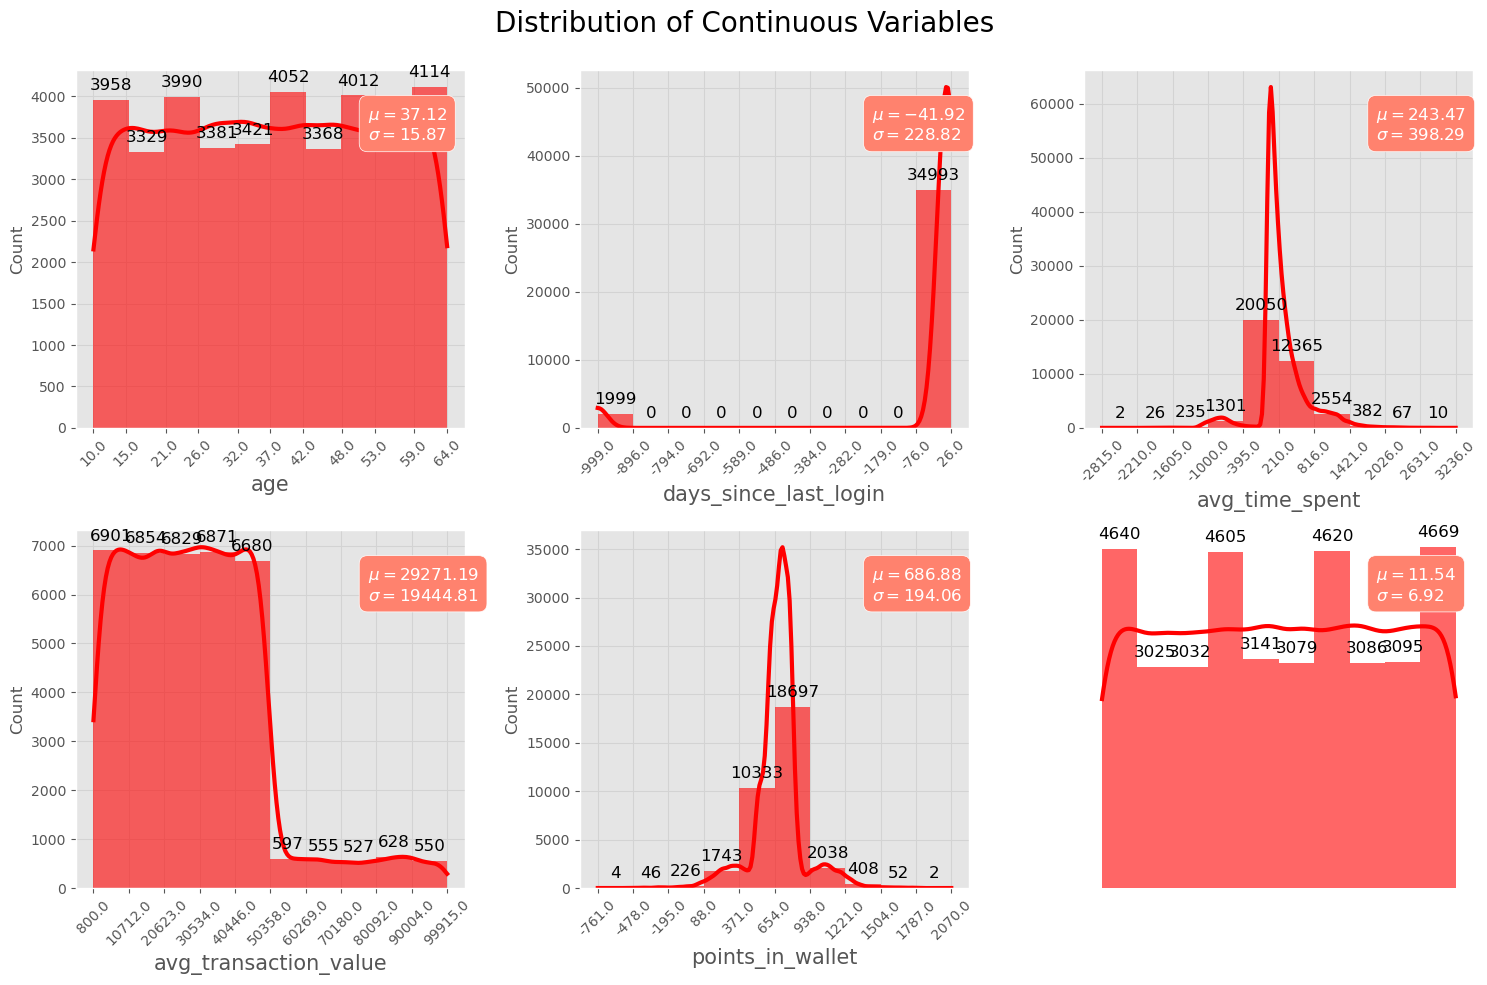

In [12]:
numerical_features = ['age', 'days_since_last_login', 
                      'avg_time_spent', 'avg_transaction_value', 
                      'points_in_wallet', 'visit_hour']

# Filter out continuous features for the univariate analysis
df_numerical = df[numerical_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_numerical.columns):
    x = i // 3
    y = i % 3
    
    values, bin_edges = np.histogram(df_numerical[col], 
                                     range=(np.floor(df_numerical[col].min()), np.ceil(df_numerical[col].max())))
    
    graph = sns.histplot(data=df_numerical, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 0))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    ax[x, y].bar_label(container = ax[x, y].containers[0],  fontsize=12, color='black', padding=5)
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_numerical[col].mean(),
        r'$\sigma=%.2f$' % df_numerical[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

* __Inferences:__
    * __Age__ (`age`): No strong peak age group, population is evenly spread between 15 - 58 yrs. with mean of 37.12 yrs and standard deviation of 15.82 yrs.
    * __Days Since Last Login__ (`days_since_last_login`): The distribution of “days since last login” is right-skewed, with a clear peak between 15 and 20 days. The presence of numerous negative values, which are impossible for this metric, indicates data quality issues. These erroneous values severely distort the summary statistics, resulting in an artificially low mean (−41.92) and an inflated standard deviation (228.82). Cleaning the negative and extreme values is essential for accurate analysis.
    * __Avg. Time Spent__ (`avg_time_spent`): The Distribution is somewhat normal distribution, with clear peak around 210. The presence of numerous negative values, which are impossible for this metric, indicate data quality issues. These erroneous values severly distort the summary statistics, resulting in faulty mean: 243, standard deviation: 398. Cleaning the negative and extrame values is essential for accurate analysis.
    * __Avg Transaction Value__ (`avg_transaction_value`): The Distribution of "Avg. Transaction Value" is left skewed with peak between 5800 to 45000. statistic summary of distribution; mean: 29271.19 and standard deviation: 19444.81.
    * __Points in wallet__ (`points_in_wallet`): The Distribution of "points in wallet" is somewhat normally distributed with peak is around 700. Majority of members have positive balance in their wallet. The distribution shows mean of 686 and standard deviation of 194.
    * __Visit Hour__ (`visit_hour`): No strong peak is seen in distribution.

### 4.1.2 Categorical Features Univariate Analysis

In [13]:
# Filter out categorical features for the univariate analysis
categorical_features = ['gender', 'region_category', 'membership_category',
       'joined_through_referral',
       'preferred_offer_types', 'medium_of_operation', 'internet_option',
       'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback', 'churn_risk_score']

df_categorical = df[categorical_features]


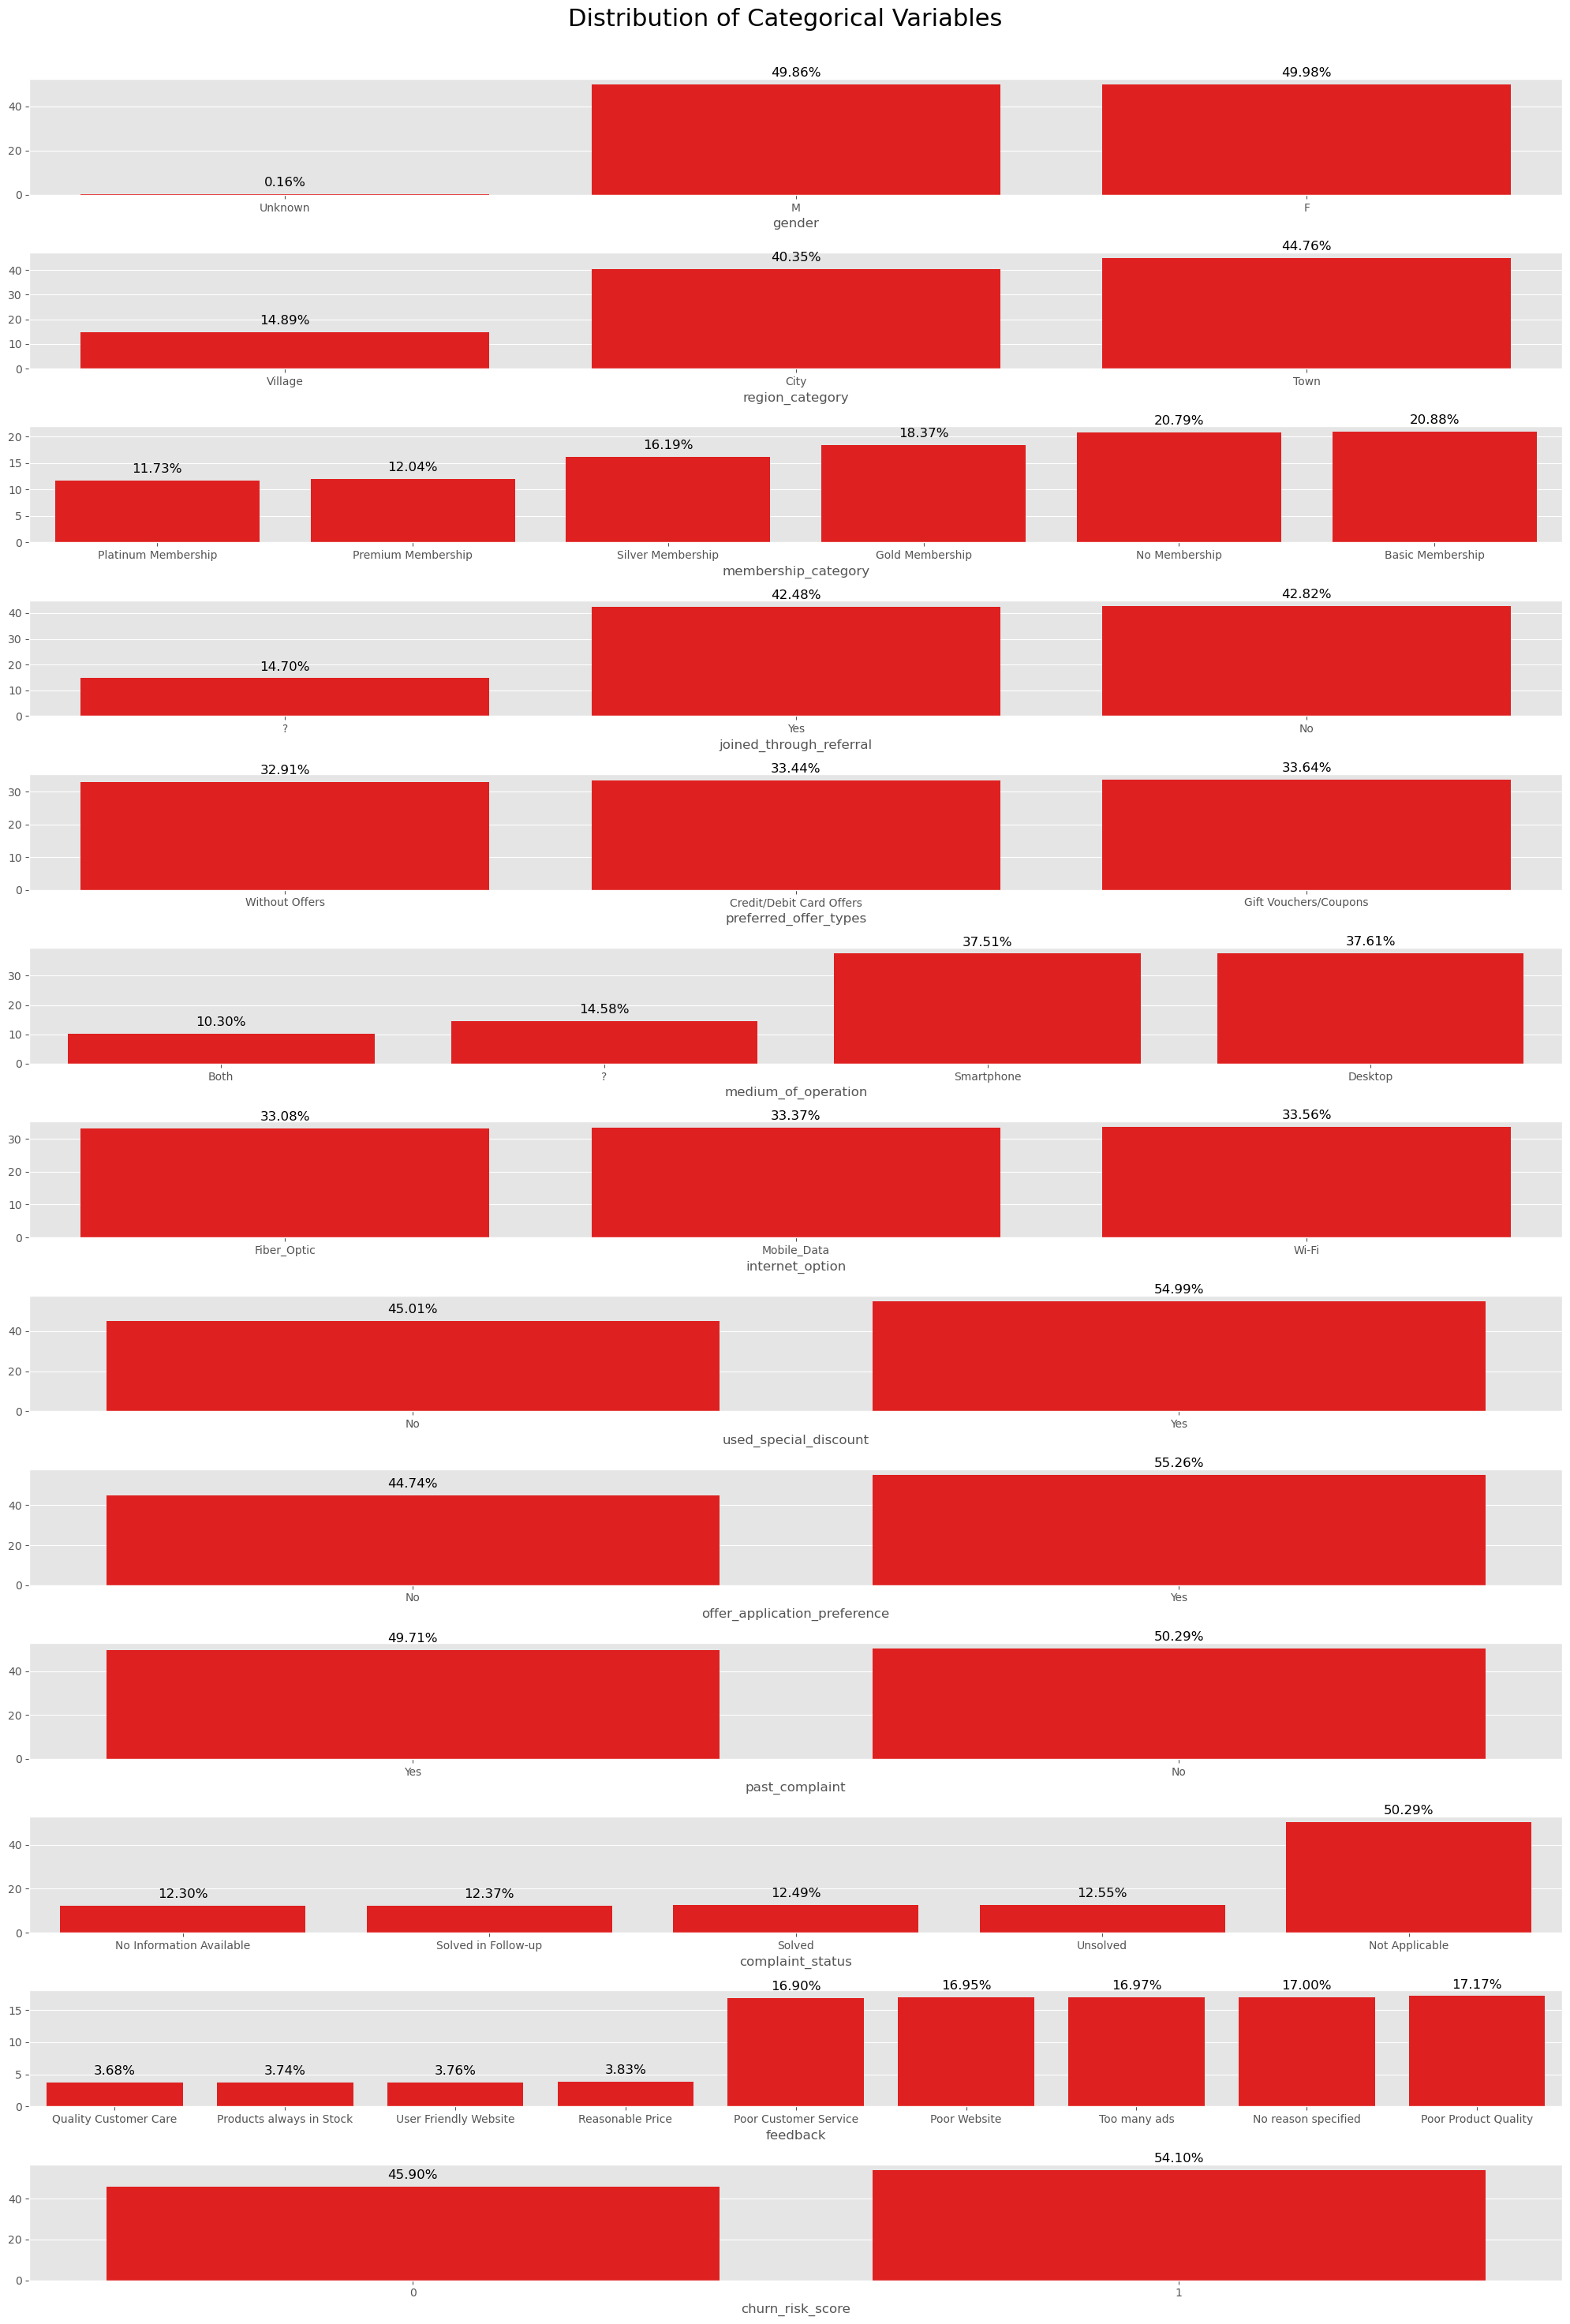

In [14]:

# Set up the subplot for a dynamic layout based on the number of features
fig, ax = plt.subplots(nrows = 13, ncols= 1, figsize=(20, 30))


# Loop to plot bar charts for each categorical feature
for i, col in enumerate(categorical_features):
    # Plot bar chart (access ax[i] since we have a 1-column layout)
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    
    sns.barplot(x = value_counts.index, y = value_counts.values, 
                    orient='v', ax = ax[i], width=0.8, color = 'red')

    ax[i].bar_label(container = ax[i].containers[0], fmt='%.2f%%', fontsize=12, color='black', padding=5)


# Overall title for the entire figure
plt.suptitle('Distribution of Categorical Variables', fontsize=22)

# Automatically adjust the layout to prevent overlap
plt.tight_layout()

# Adjust the top space to make room for the suptitle
plt.subplots_adjust(top=0.95)

# Show the plot
plt.show()


* __Inferences:__
  * `Gender`: Dataset shows distribution of gender is approximately similar and balanced.
  * `region_category`: Dataset shows majorityof members are from Town and City constitute majority share of 44% or 40%.
  * `membership_category`: A significant majority of memebers has No Membership or Basic Membership.
  * `joined_through_referrals`: Dataset is mostly balanced in this feature, It also suggests 14% value missing.
  * `preferred_offer_types`: This feature is balnced as well.
  * `medium_operation`:  According to dataset members generally used Smartphones or Desktop as medium of operation. with similar count 37%.
  * `internet_option`: This feature is balanced with Fiber_optic, Mobile Data, Wifi having similar shares.
  * `used_special_discount`: Majority of members uses special discount.
  * `offer_application_preferences`: Majority of members has set offer preference in application as yes.
  * `past_complaint`: Majority of members havent complaint.
  * `complaint_status`: Majority of Complaint left unresolved.
  * `feedback`: Dataset show majority of feedback given to the platforms are negative.
  * `churn_risk_score`: Dataset suggests majority of members shows higher risk of stop using services. 


## 4.2 Bivariate EDA

For our __bivariate analysis__ on the dataset's features with respect to the target variable:

* For __continuous data__: I am going to use __bar plots__ to showcase the average value of each feature for the different target classes, and __KDE plots__ to understand the distribution of each feature across the target classes. This aids in discerning how each feature varies between the two target outcomes.

    
* For __categorical data__: I am going to employ __100% stacked bar plots__ to depict the proportion of each category across the target classes. This offers a comprehensive view of how different categories within a feature relate to the target.

Through these visualization techniques, we are going to gain a deeper understanding of the relationship between individual features and the target, revealing potential predictors for heart disease.

### 4.2.1 Numerical Fetures vs Target

I am going to visualize each continuous feature against the target using two types of charts: 

* __Bar plots__ - showing the mean values.
* __KDE plots__ - displaying the distribution for each target category.

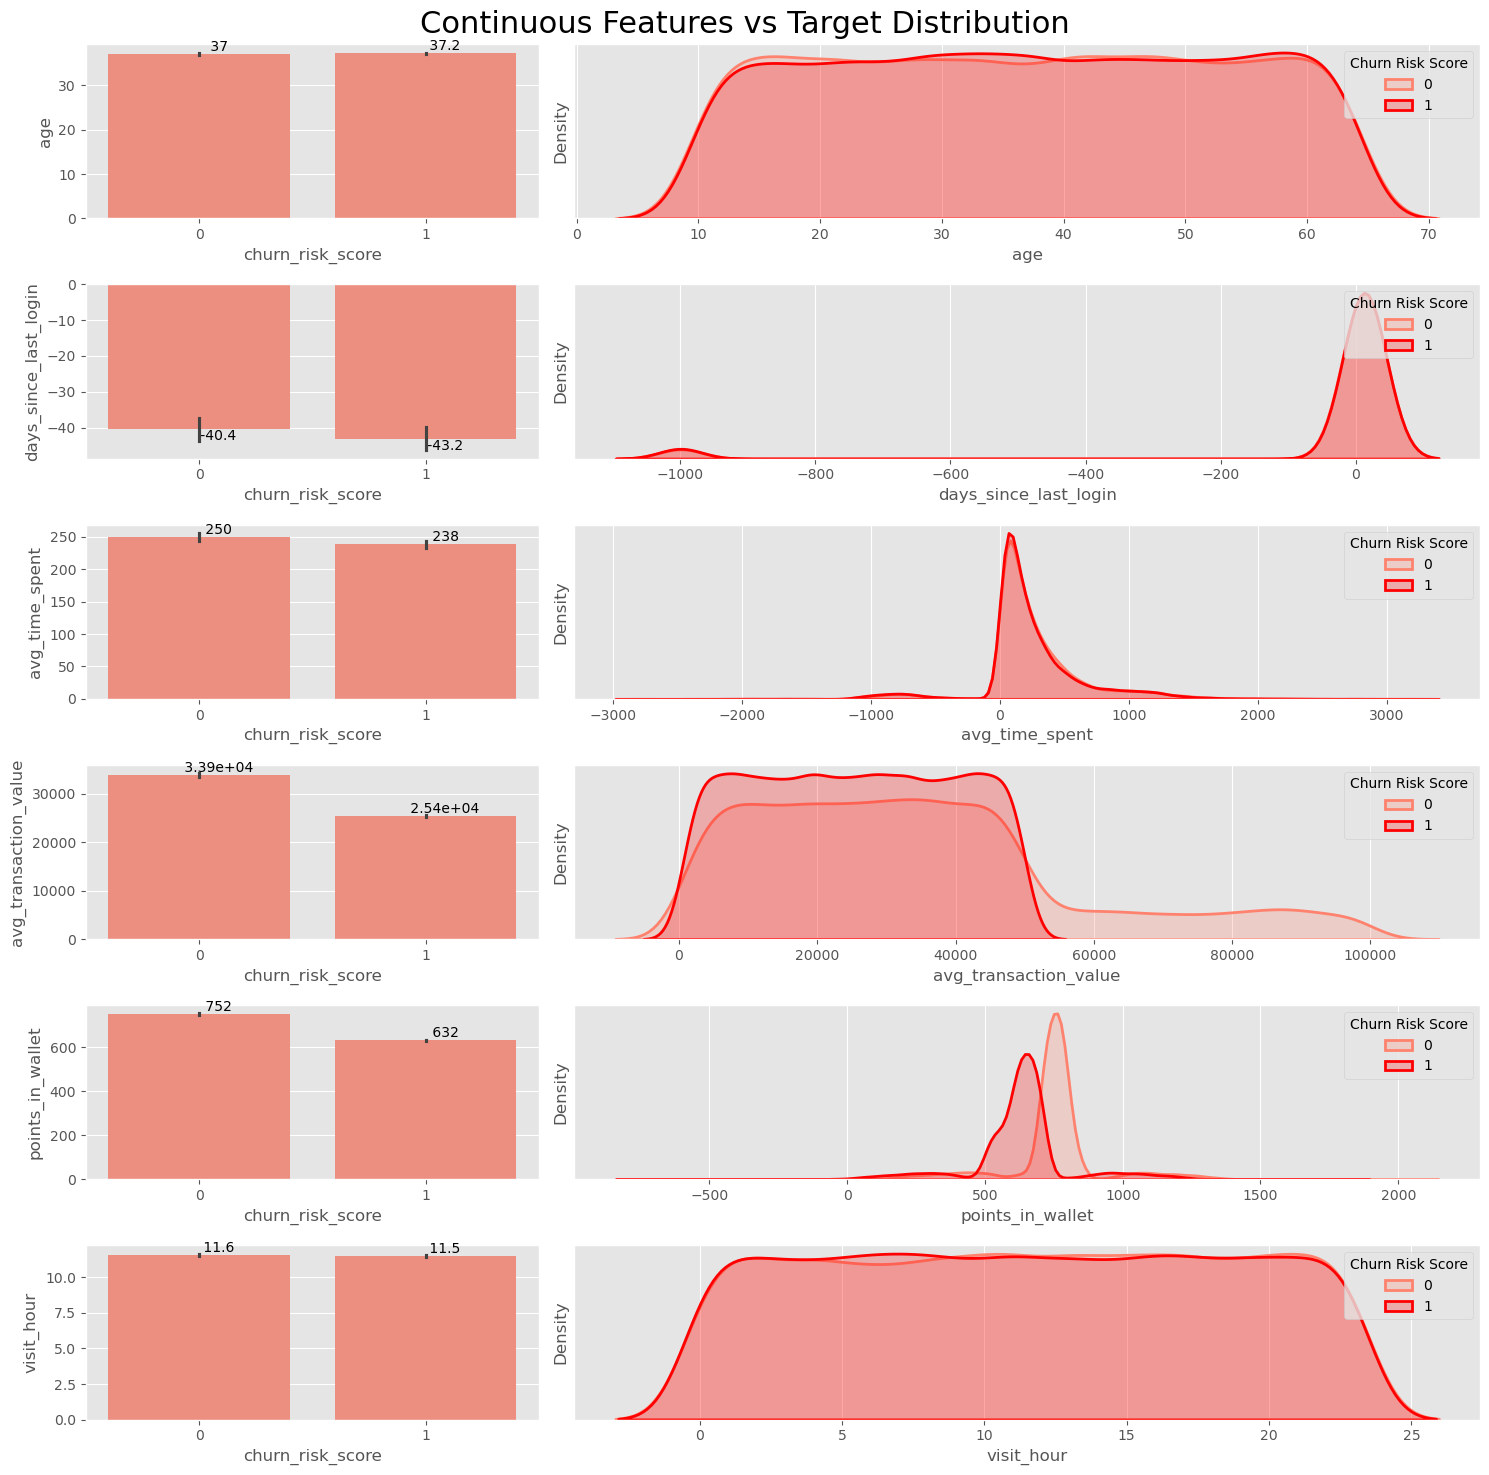

In [16]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(numerical_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(numerical_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="churn_risk_score", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["churn_risk_score"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["churn_risk_score"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Churn Risk Score', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

* __Inferences:__
    * __Age__ (`age`): Both categories display overlapping distribution in KDE plot, with nearly identical mean values, indicating limiting diffrentiating power for this feature.
    * __Days since last login__ (`days_since_last_login`):  Both categories display overlapping distribution in KDE plot. Members who doesn't login frequently on portal tends to have higher risk. but as we saw above distribution contains extreme negative values and errors, we need to clean the feature for better analysis.
    * __Avg Time Spent__ (`avg_time_spent`): Both categories display overlapping distributions in KDE plot. Members who spent higher avg time on portals tends to have lower risk score compared to member who spent less time. .indicating smaller diffrentiating power for this feature.
    * __Avg Transaction Value__ (`avg_transaction_value`): There's is noticable difference in distribution of two categories. Members with higher avg. transaction value tends to have lower risk score. Risky members avg transaction value lies between 0 and 57000. After 57000 there is little to low riskscore of members dropping out.
    * __points_in_wallet__ (`points in wallet`): There is an noticeable diffrence between the distributions of two categories. Members with higher points in wallets tends to have lower risk score.
    * __Visit Hour__ (`visit_hour`): Both categories show similar distribution in KDE Distribution plot with identical mean values, indicating limited diffrentiating power of feature.

### 4.2.2 Categorical Features vs Target


* I am going to display __100% stacked bar plots__ for each categorical feature illustrating the proportion of each category across the two target classes, complemented by the exact counts and percentages on the bars.

In [17]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'churn_risk_score']

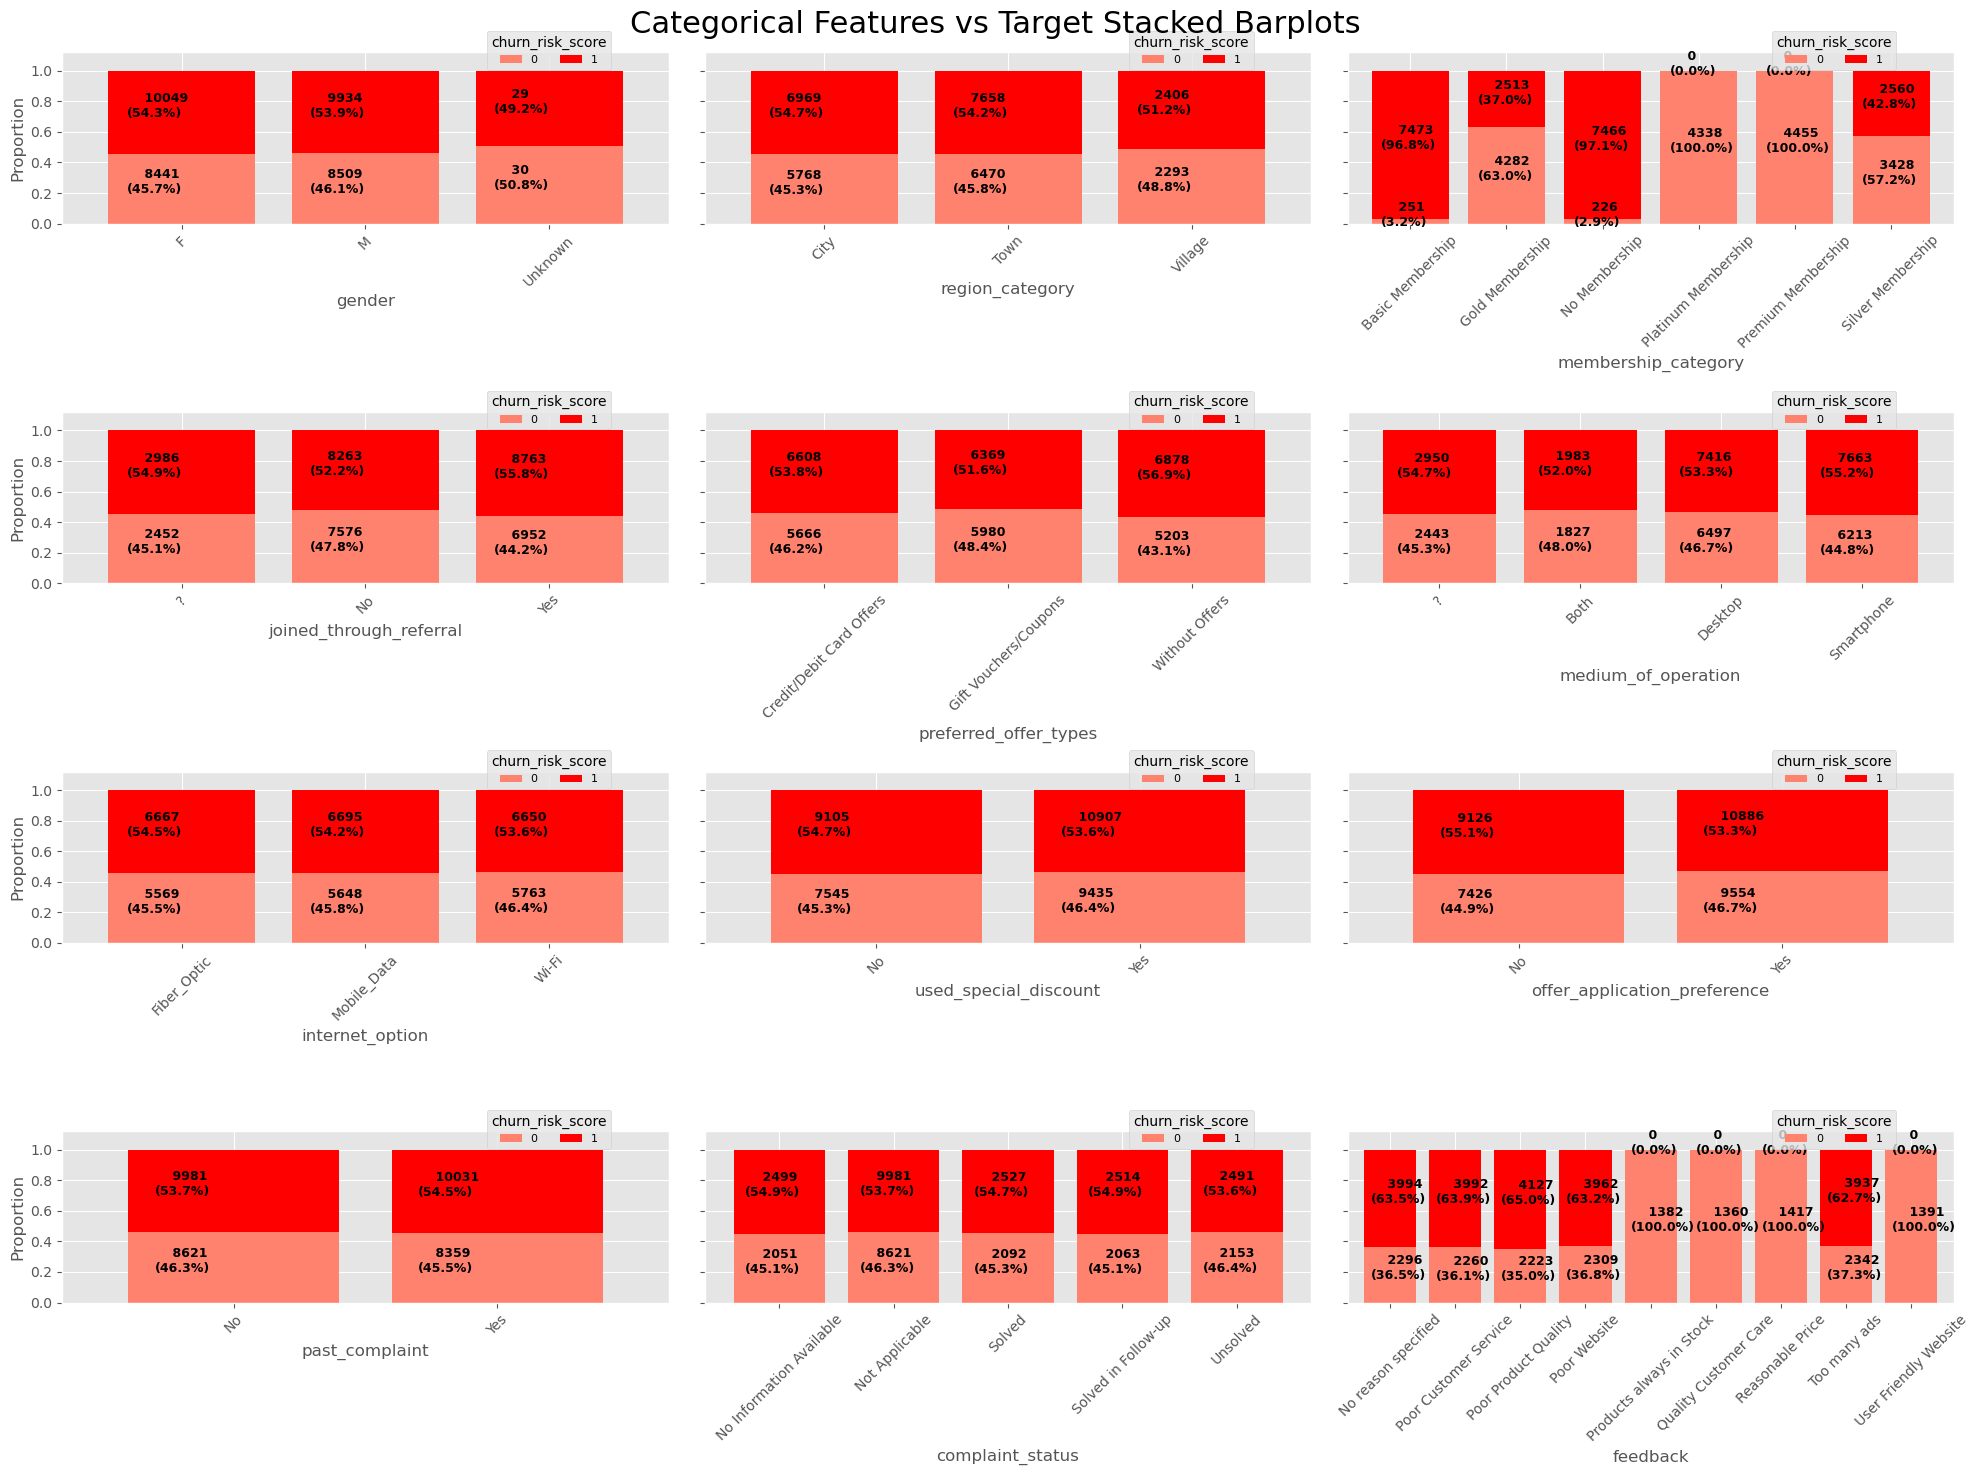

In [32]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,15))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['churn_risk_score'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['churn_risk_score'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='churn_risk_score', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
        
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=45)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

__Inferences:__
- __Gender__ (`gender`): Distribution Between diffrent Genders Male, Female, unknown have similar risk suggesting gender is not a good feature for predicting risk score.
- __Region Category__ (`region_category`): Distribution between diffrent Regions are have similar risk other than village which has slightly low risk but still is not impacting risk score suggests it might be bad predictor.
- __Membership Category__ (`membership_category`): Distribution suggests feature as high impact on predicting risk score: __No Membership > Basic Membership > Silver Membership > Gold Membership > Premium Membership > Platinium Membership__ 
- __Joined through refferal__ (`joined_through_refferal`): Distribution shows limited impact on predicting Risk score of customers.
- __Preferred Offer Types__ (`preffered_offer_types`): 

## 4.3 Multivariate EDA